In [21]:
# Some minor setup for the notebook
import warnings
import nest_asyncio

# Ignore all warnings
warnings.filterwarnings("ignore")

# Allows for running async code in Jupyter notebooks
nest_asyncio.apply()

In [12]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [7]:
from datasets import load_dataset

ms_marco = load_dataset("microsoft/ms_marco", "v2.1")

In [17]:
def mean_reciprocal_rank(retrieved_list, relevant_list):
    ranks = []
    for relevant in relevant_list:
        try:
            rank = retrieved_list.index(relevant) + 1
        except ValueError:
            rank = len(retrieved_list) + 1  # Not found
        ranks.append(rank)
    return 1.0 / min(ranks) if ranks else 0.0

# Use subset for demonstration
subset = ms_marco['train'].select(range(50))

In [8]:
print(subset[2]['query'])

why did stalin want control of eastern europe


In [9]:
from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document

In [11]:
# Prepare the documents for BM25
bm25_docs = [Document(page_content=passage) for data in subset for passage in data['passages']['passage_text']]

# Initialize BM25 Retriever
bm25_retriever = BM25Retriever.from_documents(bm25_docs)

In [18]:
import os
from ragstack_colbert import CassandraDatabase, ColbertEmbeddingModel

keyspace = "benchmarksmarco50"
database_id = os.getenv("ASTRA_DATABASE_ID")
astra_token = os.getenv("ASTRA_TOKEN")

database = CassandraDatabase.from_astra(
    astra_token=astra_token,
    database_id=database_id,
    keyspace=keyspace
)

embedding_model = ColbertEmbeddingModel()

/Users/tiernan.lindauer/PycharmProjects/benchmark-v2/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/tiernan.lindauer/PycharmProjects/benchmark-v2/.venv/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [14]:
from ragstack_langchain.colbert import ColbertVectorStore as LangchainColbertVectorStore

lc_vector_store = LangchainColbertVectorStore(
    database=database,
    embedding_model=embedding_model,
)

In [15]:
all_texts = []
all_metadatas = []
i = 0
for row in subset:
    all_texts.extend(row['passages']['passage_text'])
    all_metadatas.extend([{'row_id': i} for _ in row['passages']['is_selected']])
    i += 1


In [16]:
lc_vector_store.add_texts(all_texts, metadatas=all_metadatas)

/Users/tiernan.lindauer/PycharmProjects/benchmark-v2/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/tiernan.lindauer/PycharmProjects/benchmark-v2/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 

In [22]:
mrrs = []
for row in subset:
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    raw_results = lc_vector_store.similarity_search(query, k=n_results)
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']
    
    mrr = mean_reciprocal_rank(retrieved_list, relevant_list)
    mrrs.append(mrr)


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . )what was the immediate impact of the success of the manhattan project?, 		 True, 		 None
#> Output IDs: torch.Size([17]), tensor([ 101,    1, 1007, 2054, 2001, 1996, 6234, 4254, 1997, 1996, 3112, 1997,
        1996, 7128, 2622, 1029,  102])
#> Output Mask: torch.Size([17]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])



In [23]:
print(f"Mean Reciprocal Rank: {sum(mrrs) / len(mrrs):.4f}")

Mean Reciprocal Rank: 0.6000


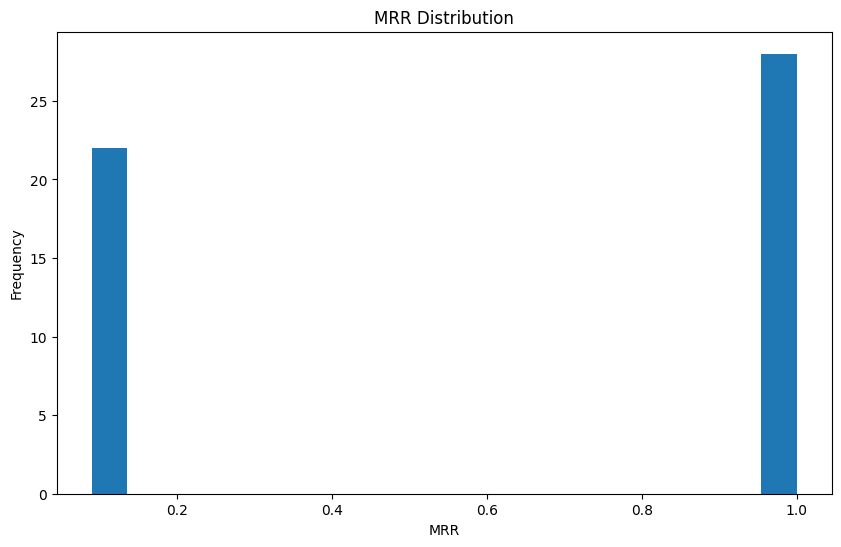

In [24]:
import matplotlib.pyplot as plt

plt.hist(mrrs, bins=20)
plt.title("MRR Distribution")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(10, 6)